# Comparing Hohmann and bielliptic transfers

Import neecessary modules

In [47]:
pip install nbformat==4.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.1 MB/s eta 0:00:00
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.8.0
    Uninstalling nbformat-5.8.0:
      Successfully uninstalled nbformat-5.8.0
Note: you may need to restart the kernel to use updated packages.


In [48]:
from astropy import units as u
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from poliastro.bodies import Earth
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
import plotly.graph_objs as go
from plotly.subplots import make_subplots


## Define multiple transfer functions
We will compare multiple transfer functions.  We will define a function for each transfer type. The functions will take the initial and final orbital elements as input and return the time of flight and the delta-v required for the transfer. The functions will also plot the transfer orbit.

In [49]:
ZOOM = True

R = np.linspace(2, 75, num=100)
Rstar = [15.58, 40, 60, 100, 200, np.inf]

hohmann_data = np.zeros_like(R)
bielliptic_data = np.zeros((len(R), len(Rstar)))

ss_i = Orbit.circular(Earth, 1.8 * u.km)
r_i = ss_i.a
v_i = np.sqrt(ss_i.v @ ss_i.v)
for ii, r in enumerate(R):
    r_f = r * r_i
    man = Maneuver.hohmann(ss_i, r_f)
    hohmann_data[ii] = (man.get_total_cost() / v_i).decompose().value
    for jj, rstar in enumerate(Rstar):
        r_b = rstar * r_i
        man = Maneuver.bielliptic(ss_i, r_b, r_f)
        bielliptic_data[ii, jj] = (
            (man.get_total_cost() / v_i).decompose().value
        )

idx_max = np.argmax(hohmann_data)

ylims = (0.35, 0.6)

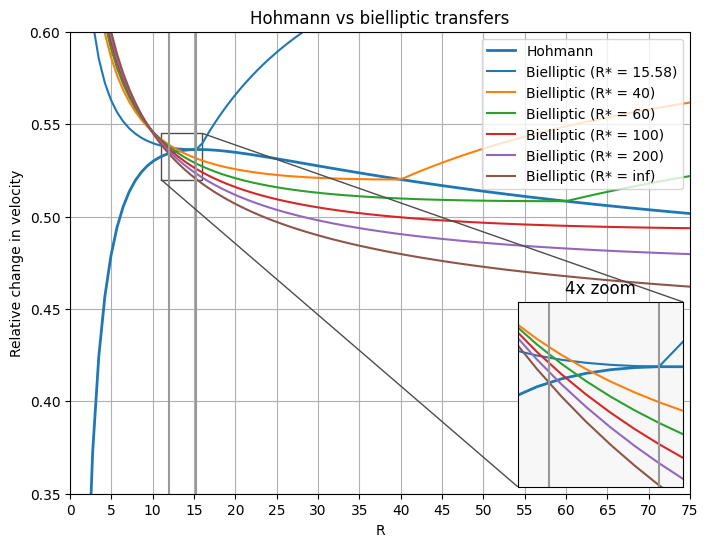

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

(l,) = ax.plot(R, hohmann_data, lw=2)
color_list = ["C0", "C1", "C2", "C3", "C4", "C5"]
for jj in range(len(Rstar)):
    # add a line for each Rstar with a different color
    current_jj_index = range(jj, len(Rstar), len(Rstar))
    current_color = color_list[current_jj_index[0]]
    ax.plot(R, bielliptic_data[:, jj], color=current_color)
ax.vlines([11.94, R[idx_max]], *ylims, color="0.6")

if ZOOM:
    ax_zoom = zoomed_inset_axes(
        ax, 4, loc=4, axes_kwargs={"facecolor": "0.97"}
    )
    ax_zoom.plot(R, hohmann_data, lw=2)
    for jj in range(len(Rstar)):
        current_jj_index = range(jj, len(Rstar), len(Rstar))
        current_color = color_list[current_jj_index[0]]
        ax_zoom.plot(R, bielliptic_data[:, jj], color=current_color)
    ax_zoom.vlines([11.94, R[idx_max]], *ylims, color="0.6")

    ax_zoom.set_xlim(11.0, 16.0)
    ax_zoom.set_ylim(0.52, 0.545)
    ax_zoom.set_xticks([])
    ax_zoom.set_yticks([])
    ax_zoom.grid(False)
    ax_zoom.set_title("4x zoom")
    mark_inset(ax, ax_zoom, loc1=1, loc2=3, fc="none", ec="0.3")

ax.set_xlabel("R")
ax.set_ylabel("Relative change in velocity")
ax.set_ylim(*ylims)
ax.set_xlim(2, 75)
ax.set_title("Hohmann vs bielliptic transfers")
ax.grid(True)
ax.set_xticks(np.arange(0, 76, 5))
ax.set_yticks(np.arange(0.35, 0.61, 0.05))
ax.legend(
    ["Hohmann", "Bielliptic (R* = 15.58)", "Bielliptic (R* = 40)", "Bielliptic (R* = 60)", "Bielliptic (R* = 100)", "Bielliptic (R* = 200)", "Bielliptic (R* = inf)"],
    loc="upper right",
)

fig.savefig("hohmann-bielliptic-transfers.png")